In [117]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import sqlite3
from pprint import pprint
from typing import TypedDict, List, Annotated, Union, Dict, Any
from langchain_core.messages import BaseMessage,AIMessage,HumanMessage,SystemMessage
from pydantic import BaseModel, Field
import json
import matplotlib.pyplot as plt
from langgraph.graph import StateGraph, END, add_messages
import operator
from langchain_core.tools import tool
from datetime import datetime
load_dotenv()

True

In [4]:
### generating a schema description ##
conn = sqlite3.connect('/home/shivargha/langGraph-agentic-playground/SQLQuery_Agent/Chinook_Sqlite.sqlite')
cursor = conn.cursor()
## Select all tables ##
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
schema_description = ""
for table in tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    schema_description += f"\nTable: {table}\n"
    for col in columns:
        schema_description += f" - {col[1]} ({col[2]})\n"

In [5]:
pprint(schema_description)

('\n'
 'Table: Album\n'
 ' - AlbumId (INTEGER)\n'
 ' - Title (NVARCHAR(160))\n'
 ' - ArtistId (INTEGER)\n'
 '\n'
 'Table: Artist\n'
 ' - ArtistId (INTEGER)\n'
 ' - Name (NVARCHAR(120))\n'
 '\n'
 'Table: Customer\n'
 ' - CustomerId (INTEGER)\n'
 ' - FirstName (NVARCHAR(40))\n'
 ' - LastName (NVARCHAR(20))\n'
 ' - Company (NVARCHAR(80))\n'
 ' - Address (NVARCHAR(70))\n'
 ' - City (NVARCHAR(40))\n'
 ' - State (NVARCHAR(40))\n'
 ' - Country (NVARCHAR(40))\n'
 ' - PostalCode (NVARCHAR(10))\n'
 ' - Phone (NVARCHAR(24))\n'
 ' - Fax (NVARCHAR(24))\n'
 ' - Email (NVARCHAR(60))\n'
 ' - SupportRepId (INTEGER)\n'
 '\n'
 'Table: Employee\n'
 ' - EmployeeId (INTEGER)\n'
 ' - LastName (NVARCHAR(20))\n'
 ' - FirstName (NVARCHAR(20))\n'
 ' - Title (NVARCHAR(30))\n'
 ' - ReportsTo (INTEGER)\n'
 ' - BirthDate (DATETIME)\n'
 ' - HireDate (DATETIME)\n'
 ' - Address (NVARCHAR(70))\n'
 ' - City (NVARCHAR(40))\n'
 ' - State (NVARCHAR(40))\n'
 ' - Country (NVARCHAR(40))\n'
 ' - PostalCode (NVARCHAR(10))\n'
 ' 

In [6]:
llm_model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash',max_retries=2)
template = '''
You are an expert SQL data analyst, you convert natural language questions into correct and optimised SQL queries.
You are working with the following database schema:
{schema_database}

Description about the database:
The Chinook database is a sample SQL database that simulates a digital music store. \
It contains tables for artists, albums, tracks, customers, invoices, and employees 

Here is the user question:
{user_query}

Your task outline is:
1. Understand the user's query and intent
2. Identify the relevant tables and columns
3. Join tables correctly if needed
4. Filter and aggregate results appropriately
5. Return the SQL query only
'''
sql_prompt_template = ChatPromptTemplate.from_template(template)
# sql_generation = prompt_template | llm_model

In [89]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage],add_messages]
    question: HumanMessage
    on_topic_classifier: str ##on topic or off topic classifier
    next_tool_selection: Union[str,None]
    sql_query: str #Union[str,None] ##stores the SQL syntax###
    sql_query_columns: List[str]
    sql_result: Annotated[List[str],operator.concat]

In [8]:
class ClassifyQuestion(BaseModel):
    on_topic_label:str = Field(description = 'Is the question based on the schema described and can be\
                                            converted into a SQL Query?If yes -> "Yes" if not -> "No"')
    
def on_topic_classifier(state:AgentState):
    print("Inside On Topic Classifier, at present the state is:",state)
    recent_question = state['question'].content
    sys_message = SystemMessage(content= """ You are classifier that determine's if the user's question is about the following database:
            The Chinook database is a sample SQL database that simulates a digital music store. \
            It contains tables for artists, albums, tracks, customers, invoices, and employees.
            The following is the schema description of the database:
            {schema_database}
            Use the database description and schema description to understand,\
            if the question is relevant and is in the bounds of the above database, respond with a 'Yes'.Otherwise respond with a 'No'
                                    """.format(schema_database=schema_description))
    human_message = HumanMessage(content=f"User Question: {state['question'].content}")
    classfier_prompt_template = ChatPromptTemplate.from_messages([sys_message,human_message])
    structure_llm = llm_model.with_structured_output(ClassifyQuestion)
    classifier_chain = classfier_prompt_template | structure_llm
    on_topic_res = classifier_chain.invoke({})
    state['on_topic_classifier'] = str(on_topic_res.on_topic_label.strip())
    return state

In [121]:
##test the on topic node ##
on_topic_classifier({'question':HumanMessage(content="List all customers in alphabetical order")})

Inside On Topic Classifier, at present the state is: {'question': HumanMessage(content='List all customers in alphabetical order', additional_kwargs={}, response_metadata={})}


KeyboardInterrupt: 

In [110]:
class SQLOutput(BaseModel):
    sql_query:str = Field(...,description="SQL Query generated")
    sql_column_names:List[str] = Field(...,description = "List of column names after data extraction")

def SQLGenerator(state:AgentState):
    print("inside the SQLGenerator agent; state at the moment:",state)
    recent_question = state['question'].content
    structure_llm = llm_model.with_structured_output(SQLOutput)
    sql_generation = sql_prompt_template | structure_llm
    state['messages'].append(HumanMessage(content=recent_question))
    sql_query_out = sql_generation.invoke({"schema_database":schema_description,"user_query":recent_question})
    print(sql_query_out)
    state['sql_query'] = sql_query_out.sql_query
    state['sql_query_columns'] = sql_query_out.sql_column_names
    state['next_tool_selection'] = 'sqlexecutor'
    state['messages'].append(AIMessage(content=sql_query_out.sql_query))
    return state

In [60]:
state_after_sqlgen = SQLGenerator({"messages":[],'sql_result':"",\
                                   "question":HumanMessage(content="Show monthly revenue from invoice sales")})
state_after_sqlgen 

inside the SQLGenerator agent; state at the moment: {'messages': [], 'sql_result': '', 'question': HumanMessage(content='Show monthly revenue from invoice sales', additional_kwargs={}, response_metadata={})}
sql_query="SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Total) AS revenue FROM Invoice GROUP BY month ORDER BY month;" sql_column_names=['month', 'revenue']


{'messages': [HumanMessage(content='Show monthly revenue from invoice sales', additional_kwargs={}, response_metadata={}),
  AIMessage(content="SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Total) AS revenue FROM Invoice GROUP BY month ORDER BY month;", additional_kwargs={}, response_metadata={})],
 'sql_result': '',
 'question': HumanMessage(content='Show monthly revenue from invoice sales', additional_kwargs={}, response_metadata={}),
 'sql_query': "SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Total) AS revenue FROM Invoice GROUP BY month ORDER BY month;",
 'sql_query_columns': ['month', 'revenue'],
 'next_tool_selection': 'sqlexecutor'}

In [105]:
def SQLExecutor(state:AgentState):
    if state['next_tool_selection'] == 'sqlexecutor':
        sql_query_code = state['sql_query']
        try:
            conn = sqlite3.connect("/home/shivargha/langGraph-agentic-playground/SQLQuery_Agent/Chinook_Sqlite.sqlite")
            result = conn.execute(sql_query_code).fetchall()
            
            print(result)
            
            if len(state['sql_query_columns']) == 1:
                #print([i[0] for i in result])
                result = [i[0] for i in result]
                state['sql_result'] = json.dumps(result)

            else:
                data1 = []
                data2 = []
                col_names_reindexed = []
                for i in result:
                    if len(i) > 1:
                        data1.append(i[0])
                        data2.append(i[1])
                print(data1,data2)
                column_names = state['sql_query_columns']
                title = state['question'].content

                ##############################################################
                
                if all(isinstance(x, str) for x in data1):
                    print('1a')
                    if all(isinstance(x, int) for x in data2):
                        print('1b')
                        dict_data = {k:v for k,v in zip(data1,data2)}
                        col_names_reindexed = column_names
                        state['sql_result'] = json.dumps(dict_data)
                        #state['sql_query_columns']
                    elif all(isinstance(x, float) for x in data2):
                        print('1b')
                        dict_data = {k:v for k,v in zip(data1,data2)}
                        col_names_reindexed = column_names
                        state['sql_result'] = json.dumps(dict_data)
                        
                elif all(isinstance(x, str) for x in data2):
                    if all(isinstance(x, int) for x in data1):
                        dict_data = {k:v for k,v in zip(data2,data1)}
                        col_names_reindexed = column_names[::-1]
                        state['sql_result'] = json.dumps(dict_data)
                        state['sql_query_columns'] = col_names_reindexed
                        
                    elif all(isinstance(x, float) for x in data1):
                        dict_data = {k:v for k,v in zip(data2,data1)}
                        col_names_reindexed = column_names[::-1]
                        state['sql_result'] = json.dumps(dict_data)
                        state['sql_query_columns'] = col_names_reindexed

            ####################################################################################

            #  #################### Data for Line Chart ###################################

            #     elif all(datetime.strptime(date, format)  for date in data1):
            #         print(1)
            #         if all(isinstance(x, float) for x in data2):
            #             dict_data = {k:v for k,v in zip(data1,data2)}
            #             #print(dict_data)
            #             col_names_reindexed = column_names
            #             state['sql_result'].append(json.dumps(dict_data))
            #         elif all(isinstance(x, int) for x in data2):
            #             dict_data = {k:v for k,v in zip(data1,data2)}
            #             #print(dict_data)
            #             col_names_reindexed = column_names
            #     else:
            #         print('Y')
            #         dict_data = {k:v for k,v in zip(data2,data1)}
            #         col_names_reindexed = column_names[::-1]
                    
            # ####################################################################################
                                
            return state
        except Exception as error:
            #state['sql_result'].append(json.dumps(result))
            print(error)
            return state

In [61]:
state_after_sqlexec = SQLExecutor(state_after_sqlgen)
state_after_sqlexec

[('2009-01', 35.64), ('2009-02', 37.62), ('2009-03', 37.62), ('2009-04', 37.62), ('2009-05', 37.62), ('2009-06', 37.62), ('2009-07', 37.62), ('2009-08', 37.62), ('2009-09', 37.62), ('2009-10', 37.62), ('2009-11', 37.62), ('2009-12', 37.62), ('2010-01', 52.62), ('2010-02', 46.62), ('2010-03', 44.62), ('2010-04', 37.62), ('2010-05', 37.62), ('2010-06', 37.62), ('2010-07', 37.62), ('2010-08', 37.62), ('2010-09', 36.63), ('2010-10', 37.62), ('2010-11', 37.62), ('2010-12', 37.62), ('2011-01', 37.62), ('2011-02', 37.62), ('2011-03', 37.62), ('2011-04', 51.62), ('2011-05', 42.62), ('2011-06', 50.62), ('2011-07', 37.62), ('2011-08', 37.62), ('2011-09', 37.62), ('2011-10', 37.62), ('2011-11', 23.76), ('2011-12', 37.62), ('2012-01', 37.62), ('2012-02', 37.62), ('2012-03', 37.62), ('2012-04', 37.62), ('2012-05', 37.62), ('2012-06', 37.62), ('2012-07', 39.62), ('2012-08', 47.62), ('2012-09', 46.71), ('2012-10', 42.62), ('2012-11', 37.62), ('2012-12', 37.62), ('2013-01', 37.62), ('2013-02', 27.72),

{'messages': [HumanMessage(content='Show monthly revenue from invoice sales', additional_kwargs={}, response_metadata={}),
  AIMessage(content="SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Total) AS revenue FROM Invoice GROUP BY month ORDER BY month;", additional_kwargs={}, response_metadata={})],
 'sql_result': '{"2009-01": 35.64, "2009-02": 37.62, "2009-03": 37.62, "2009-04": 37.62, "2009-05": 37.62, "2009-06": 37.62, "2009-07": 37.62, "2009-08": 37.62, "2009-09": 37.62, "2009-10": 37.62, "2009-11": 37.62, "2009-12": 37.62, "2010-01": 52.62, "2010-02": 46.62, "2010-03": 44.62, "2010-04": 37.62, "2010-05": 37.62, "2010-06": 37.62, "2010-07": 37.62, "2010-08": 37.62, "2010-09": 36.63, "2010-10": 37.62, "2010-11": 37.62, "2010-12": 37.62, "2011-01": 37.62, "2011-02": 37.62, "2011-03": 37.62, "2011-04": 51.62, "2011-05": 42.62, "2011-06": 50.62, "2011-07": 37.62, "2011-08": 37.62, "2011-09": 37.62, "2011-10": 37.62, "2011-11": 23.76, "2011-12": 37.62, "2012-01": 37.62, "2012-02": 

In [ ]:
data2 =37.62, 37.62, 42.62, 37.62, 190.1, 303.96, 46.62, 90.24, 37.62, 41.62, 195.1, 156.48, 45.62, 75.26, 45.62, 37.62,\
40.62, 39.62, 37.62, 77.24, 37.62, 38.62, 523.06, 112.86]


In [45]:
@tool
def text_listing_tool(data: List[str], title: str) -> str:
    """
    Displays a list of textual entries as bullet points.

    Use this tool when the SQL result returns only textual data (e.g., names of albums, artists, genres).
    
    Args:
        data (List[str]): A list of strings representing text records.
        title (str): A title or user query summarizing what the list represents.

    Returns:
        str: A formatted string with bullet points for each entry.

    Example: 
        Input:
            data = ["Black Album", "Master of Puppets"]
            title = "Albums by Metallica"

        Output:
            Albums by Metallica:
            • Black Album
            • Master of Puppets

    """
    print(title)
    for i in data:
        print("* "+i)
        #print("\n")
    #column_names = state_after_sqlexec['sql_query_columns']
# title = state_after_sqlexec['question'].content
# text_listing_tool(data_extracted,title)

In [24]:
@tool
def bar_chart_tool(data: Dict[str, float], title: str, x_axis: str, y_axis: str) -> str:
    '''
    Generates a bar chart from categorical-numeric pairs.

    Use this tool when the SQL result includes categories (e.g., countries, genres) with corresponding numeric values (e.g., revenue, sales count).

    Args:
        data (Dict[str, float]): Dictionary with category names as keys and numeric values as values.
        title (str): The user query used here as the title
        x_axis (str): Using state["sql_query_columns"][0] for the x-axis label (categorical like country,Name etc).
        y_axis (str): Using state["sql_query_columns"][1] for the y-axis (numerical like 37.87, 89, 98.2).

    Returns:
        str: Filepath of the plot.

    Example:
        Input:
            data = {"USA": 523.06, "India": 75.26}
            title = "Revenue by Country"
            x_axis = "Country"
            y_axis = "Revenue (USD)"
        
    '''
    plt.figure(figsize=(11,13))
    plt.bar(list(data.keys()), list(data.values()),width=0.3)
    plt.title(title)
    plt.xlabel(x_axis,fontweight='bold')
    plt.ylabel(y_axis,fontweight='bold')
    #plt.xticks(rotation=90)
    plt.show()
    save_path = "barchart.png"
    plt.savefig(save_path)
    return save_path

In [18]:
@tool
def line_chart_tool(data:Dict[str,float],x_axis:str,y_axis:str,title:str):
    '''
    Creates a line chart from time series data.

    Use this tool when the SQL result includes time-based keys (e.g., months, dates) and numeric values (e.g., monthly sales, revenue).

    Args:
        data (Dict[str, float]): Dictionary where keys are dates (format "YYYY-MM") and values are numeric.
        title (str): The user query used here as the title
        x_axis (str): Using state["sql_query_columns"][0] for the x-axis label (datetime in 'YYYY-MM').
        y_axis (str): Using state["sql_query_columns"][1] for the y-axis label (Numeric values like 38.98,89.98, 98).

    Returns:
        str: Filepath of the plot

    Example:
        Input:
            data = {"2022-01": 100.5, "2022-02": 110.2}
            title = "Monthly Revenue"
            x_axis = "Month"
            y_axis = "Revenue (USD)"
    
    '''
    plt.figure(figsize=(11,13))
    plt.plot(list(data.keys()), list(data.values()), linewidth=2)
    plt.xlabel(x_axis,fontweight='bold')
    plt.ylabel(y_axis,fontweight='bold')
    plt.title(title)
    plt.show()
    save_path = "linechart.png"
    plt.savefig(save_path)
    return save_path

In [22]:
data_extracted = json.loads(state_after_sqlexec['sql_result'][-1])
data_extracted

[['Garage Inc. (Disc 1)'],
 ['Black Album'],
 ['Garage Inc. (Disc 2)'],
 ["Kill 'Em All"],
 ['Load'],
 ['Master Of Puppets'],
 ['ReLoad'],
 ['Ride The Lightning'],
 ['St. Anger'],
 ['...And Justice For All']]

In [296]:
format = "%Y-%m"
date = '2013-11'
res = bool(datetime.strptime(date, format))
res

True

In [302]:
if all(datetime.strptime(date, format) for date in data1):
    print(1)

1


In [357]:
##Text only##
data1 = []
for i in data_extracted:
    #print(i)
    if len(i) == 1:
        print("*"+i[0])
        #print("\n")
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content


*Garage Inc. (Disc 1)
*Black Album
*Garage Inc. (Disc 2)
*Kill 'Em All
*Load
*Master Of Puppets
*ReLoad
*Ride The Lightning
*St. Anger
*...And Justice For All


In [355]:
for i in data1:
    print(i)

Garage Inc. (Disc 1)
Black Album
Garage Inc. (Disc 2)
Kill 'Em All
Load
Master Of Puppets
ReLoad
Ride The Lightning
St. Anger
...And Justice For All


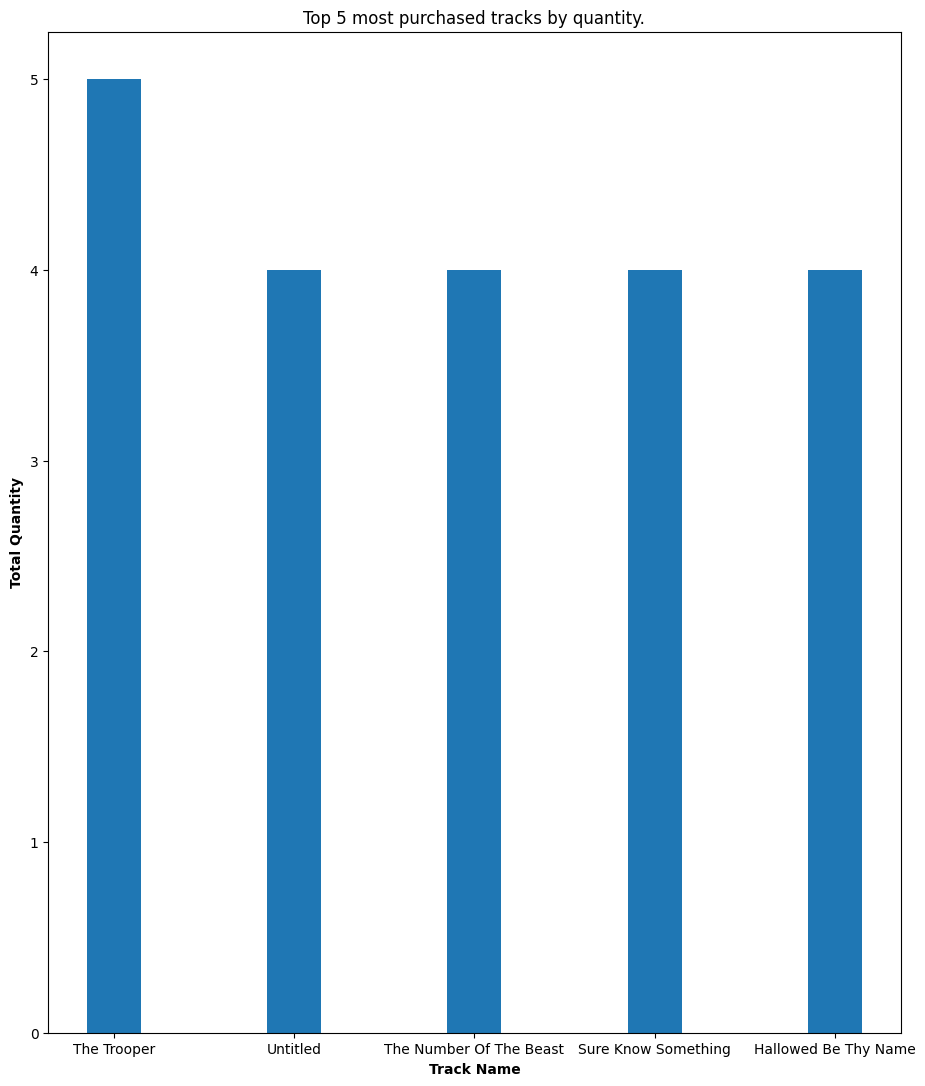

In [332]:
data1 = []
data2 = []
col_names_reindexed = []
for i in data_extracted:
    if len(i) > 1:
        data1.append(i[0])
        data2.append(i[1])
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content
if all(isinstance(x, str) for x in data1):
    if all(isinstance(x, int) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        col_names_reindexed = column_names
else:
    dict_data = {k:v for k,v in zip(data2,data1)}
    col_names_reindexed = column_names[::-1]
dict_data
bar_chart_tool(dict_data,col_names_reindexed[0],col_names_reindexed[1],title)

['month', 'revenue'] Monthly revenue trend in 2013.
1


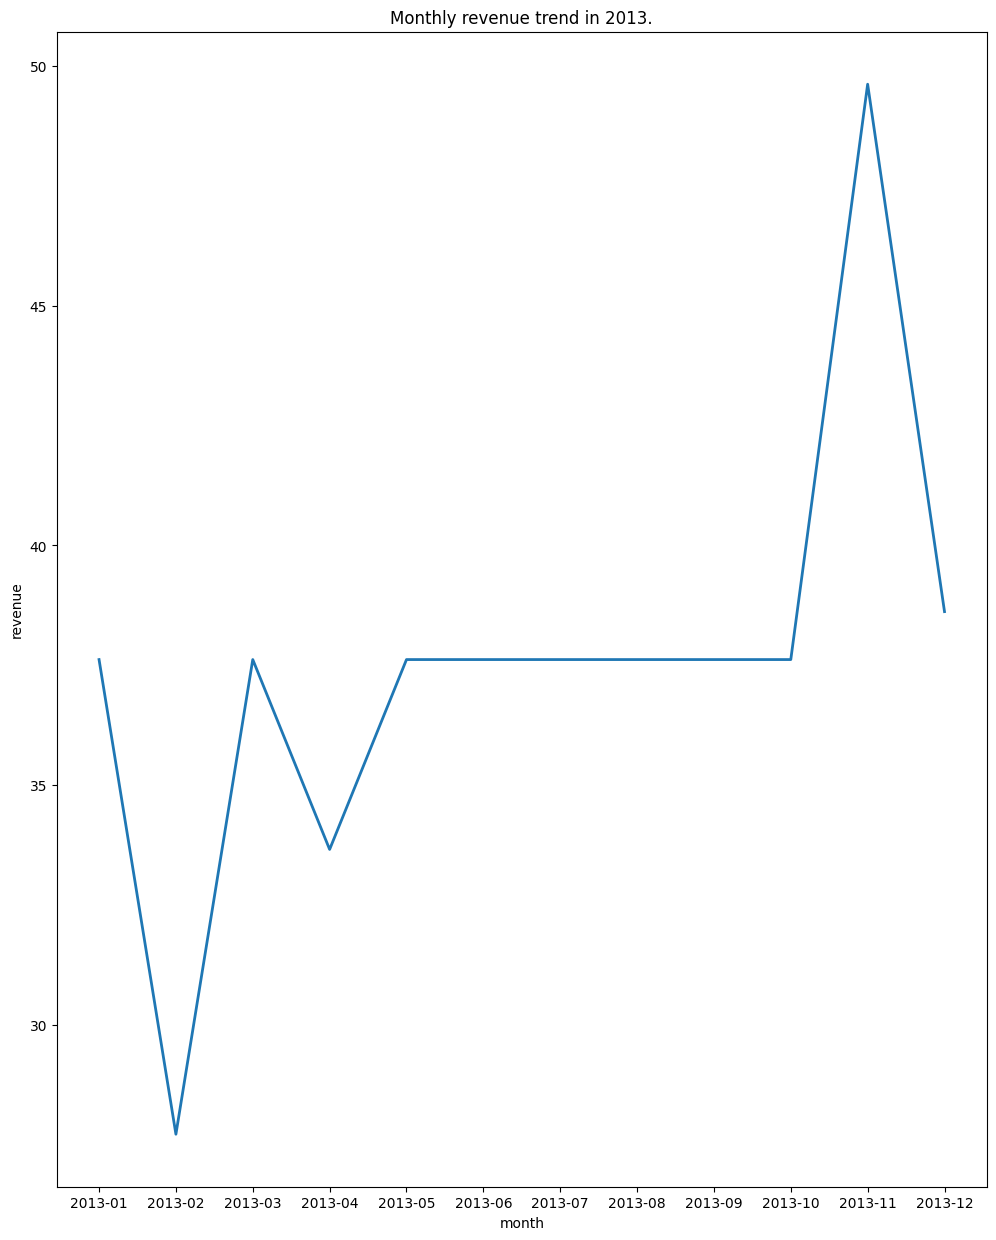

In [318]:
data1 = []
data2 = []
col_names_reindexed = []
for i in data_extracted:
    if len(i) > 1:
        data1.append(i[0])
        data2.append(i[1])
column_names = state_after_sqlexec['sql_query_columns']
title = state_after_sqlexec['question'].content
print(column_names,title)
if all(datetime.strptime(date, format)  for date in data1):
    print(1)
    if all(isinstance(x, float) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        #print(dict_data)
        col_names_reindexed = column_names
    elif all(isinstance(x, int) for x in data2):
        dict_data = {k:v for k,v in zip(data1,data2)}
        #print(dict_data)
        col_names_reindexed = column_names
else:
    dict_data = {k:v for k,v in zip(data2,data1)}
    col_names_reindexed = column_names[::-1]


dict_data
line_chart_tool(dict_data,col_names_reindexed[0],col_names_reindexed[1],title)

In [20]:
def reactNode(state:AgentState):
    tools = [text_listing_tool, bar_chart_tool, line_chart_tool]
    llm_with_tools = llm_model.bind_tools(tools)
    
    ACT_PROMPT = '''
    You are a data visualization agent. Based on the following context, choose the appropriate tool from one of the following:
    - `bar_chart_tool`: use when one column is categorical (like names, genres) and another is numeric.
    - `line_chart_tool`: use when one column is a time/date and another is numeric (e.g., monthly revenue).
    - `text_listing_tool`: use when data is purely text-based.
    
    Respond by calling the correct tool with the appropriate SQL result data.
    
    ---
    
    User Query: {user_query}
    
    LLM's SQL Response: {ai_message}
    
    SQL Query Result (sample): {sql_result}
    
    Column Names: {column_names}
    '''
    
    prompt_template = ChatPromptTemplate.from_template(ACT_PROMPT)
    chain = prompt_template | llm_with_tools
    ai_message = chain.invoke({'user_query':state_after_sqlexec['messages'][-2].content,
                 'ai_message':state_after_sqlexec['messages'][-1].content,
                 'sql_result':state_after_sqlexec['sql_result'][-1],
                 'column_names':state_after_sqlexec['sql_query_columns']})
    state['messages'].append(ai_message)
    return state

In [21]:
state_after_sqlexec

{'messages': [HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
  AIMessage(content='SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"', additional_kwargs={}, response_metadata={})],
 'sql_result': '["Garage Inc. (Disc 1)", "Black Album", "Garage Inc. (Disc 2)", "Kill \'Em All", "Load", "Master Of Puppets", "ReLoad", "Ride The Lightning", "St. Anger", "...And Justice For All"]',
 'question': HumanMessage(content='List all albums released my metallica', additional_kwargs={}, response_metadata={}),
 'sql_query': 'SELECT Title FROM Album JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = "Metallica"',
 'sql_query_columns': ['Title'],
 'next_tool_selection': 'sqlexecutor'}

In [62]:
tools = [text_listing_tool, bar_chart_tool, line_chart_tool]
#print(tools)
llm_with_tools = llm_model.bind_tools(tools)

ACT_PROMPT = '''
You are a data visualization agent. Based on the following context, choose the appropriate tool from one of the following:
- `bar_chart_tool`: use when one column is categorical (like names, genres) and another is numeric.
- `line_chart_tool`: use when one column is a time/date and another is numeric (e.g., monthly revenue).
- `text_listing_tool`: use when data is purely text-based.

Respond by calling the correct tool with the appropriate SQL result data.

---

User Query: {user_query}

LLM's SQL Response: {ai_message}

SQL Query Result (sample): {sql_result}

Column Names: {column_names}
'''

prompt_template = ChatPromptTemplate.from_template(ACT_PROMPT)
chain = prompt_template | llm_with_tools
ai_message = chain.invoke({'user_query':state_after_sqlexec['messages'][-2].content,
             'ai_message':state_after_sqlexec['messages'][-1].content,
             'sql_result':state_after_sqlexec['sql_result'][-1],
             'column_names':state_after_sqlexec['sql_query_columns']})
ai_message

AIMessage(content='', additional_kwargs={'function_call': {'name': 'line_chart_tool', 'arguments': '{"x_axis": "Month", "title": "Monthly revenue from invoice sales", "y_axis": "Revenue", "data": [{"revenue": 1000.0, "month": "2023-01"}, {"revenue": 1100.0, "month": "2023-02"}, {"revenue": 1200.0, "month": "2023-03"}]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d5a43a2e-0226-437e-b25b-f3323b6b9933-0', tool_calls=[{'name': 'line_chart_tool', 'args': {'x_axis': 'Month', 'title': 'Monthly revenue from invoice sales', 'y_axis': 'Revenue', 'data': [{'revenue': 1000.0, 'month': '2023-01'}, {'revenue': 1100.0, 'month': '2023-02'}, {'revenue': 1200.0, 'month': '2023-03'}]}, 'id': '07dc2915-85b2-4fa5-992f-76ae0430176b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 908, 'output_tokens': 50, 'total_tokens': 958, 'input_token_details': {'cache_read': 0}})

In [63]:
state_after_sqlexec['messages'].append(ai_message)
state_after_sqlexec

{'messages': [HumanMessage(content='Show monthly revenue from invoice sales', additional_kwargs={}, response_metadata={}),
  AIMessage(content="SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Total) AS revenue FROM Invoice GROUP BY month ORDER BY month;", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'line_chart_tool', 'arguments': '{"x_axis": "Month", "title": "Monthly revenue from invoice sales", "y_axis": "Revenue", "data": [{"revenue": 1000.0, "month": "2023-01"}, {"revenue": 1100.0, "month": "2023-02"}, {"revenue": 1200.0, "month": "2023-03"}]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d5a43a2e-0226-437e-b25b-f3323b6b9933-0', tool_calls=[{'name': 'line_chart_tool', 'args': {'x_axis': 'Month', 'title': 'Monthly revenue from invoice sales', 'y_axis': 'Revenue', 'data': [{'revenue': 1000.0, 'month': '2023-01'}, {'re

In [64]:
tools_by_name = {tool.name: tool for tool in tools}

In [65]:
tools_by_name[state_after_sqlexec['messages'][-1].tool_calls[0]['name']]

StructuredTool(name='line_chart_tool', description='Creates a line chart from time series data.\n\nUse this tool when the SQL result includes time-based keys (e.g., months, dates) and numeric values (e.g., monthly sales, revenue).\n\nArgs:\n    data (Dict[str, float]): Dictionary where keys are dates (format "YYYY-MM") and values are numeric.\n    title (str): The user query used here as the title\n    x_axis (str): Using state["sql_query_columns"][0] for the x-axis label (datetime in \'YYYY-MM\').\n    y_axis (str): Using state["sql_query_columns"][1] for the y-axis label (Numeric values like 38.98,89.98, 98).\n\nReturns:\n    str: Filepath of the plot\n\nExample:\n    Input:\n        data = {"2022-01": 100.5, "2022-02": 110.2}\n        title = "Monthly Revenue"\n        x_axis = "Month"\n        y_axis = "Revenue (USD)"\n\n    Output:\n        Line chart generated showing Monthly Revenue.', args_schema=<class 'langchain_core.utils.pydantic.line_chart_tool'>, func=<function line_chart

In [66]:
data = json.loads(state_after_sqlexec['sql_result'])
title = 'ABC'
x_axis = "HH"
y_axis = 'CC'
print(data,title,x_axis,y_axis)

{'2009-01': 35.64, '2009-02': 37.62, '2009-03': 37.62, '2009-04': 37.62, '2009-05': 37.62, '2009-06': 37.62, '2009-07': 37.62, '2009-08': 37.62, '2009-09': 37.62, '2009-10': 37.62, '2009-11': 37.62, '2009-12': 37.62, '2010-01': 52.62, '2010-02': 46.62, '2010-03': 44.62, '2010-04': 37.62, '2010-05': 37.62, '2010-06': 37.62, '2010-07': 37.62, '2010-08': 37.62, '2010-09': 36.63, '2010-10': 37.62, '2010-11': 37.62, '2010-12': 37.62, '2011-01': 37.62, '2011-02': 37.62, '2011-03': 37.62, '2011-04': 51.62, '2011-05': 42.62, '2011-06': 50.62, '2011-07': 37.62, '2011-08': 37.62, '2011-09': 37.62, '2011-10': 37.62, '2011-11': 23.76, '2011-12': 37.62, '2012-01': 37.62, '2012-02': 37.62, '2012-03': 37.62, '2012-04': 37.62, '2012-05': 37.62, '2012-06': 37.62, '2012-07': 39.62, '2012-08': 47.62, '2012-09': 46.71, '2012-10': 42.62, '2012-11': 37.62, '2012-12': 37.62, '2013-01': 37.62, '2013-02': 27.72, '2013-03': 37.62, '2013-04': 33.66, '2013-05': 37.62, '2013-06': 37.62, '2013-07': 37.62, '2013-08'

In [67]:
tools_by_name[state_after_sqlexec['messages'][-1].tool_calls[0]['name']].invoke({'data':data,'title':title,\
    'x_axis':x_axis,'y_axis':y_axis})
#tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])

ValidationError: 1 validation error for line_chart_tool
data
  Input should be a valid list [type=list_type, input_value={'2009-01': 35.64, '2009-...49.62, '2013-12': 38.62}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type

In [387]:
def exec_tool(state:AgentState):

    ##check for ai message##
    if isinstance(state['messages'][-1],AIMessage):
        ai_message = state['messages'][-1]
        if hasattr(ai_message,"tool_calls"):
            tool_messages = []
            for tool_call in ai_message.tool_calls:
                tool_call_function = tool_call['name']
                call_id = tool_call["id"]

                ### data manipulatio ###


                #########################

In [385]:
if isinstance(state_after_sqlexec['messages'][-1],AIMessage):
    print(9)

9


In [388]:
if hasattr(ai_message,"tool_calls"):
    tool_messages = []
    for tool_call in ai_message.tool_calls:
        tool_call_function = tool_call['name']
        call_id = tool_call["id"]
print(call_id,tool_call_function)

504843f2-c99c-4d60-ae7b-d4378767f098 text_listing_tool


In [ ]:
tool

In [1]:
state_tool_call.tool_calls

NameError: name 'state_tool_call' is not defined